In [1]:
%pylab inline
#from ctypes import" *
import ctypes
import os
PSH=ctypes.cdll.LoadLibrary('pshmf.so')


Populating the interactive namespace from numpy and matplotlib


In [2]:
#initiallize for calculating sig(M):
redshift = 0.45
m1   = 13
M1   = 10.**m1/1e10
M2   = 10.**np.arange(m1,m1+1,0.001)/1e10
S2   = np.zeros(M2.shape[0],dtype=np.double)
temp = np.zeros(2,dtype=np.double)

#initiallize for calculating dc:
zmin,zmax,nz = 0,0.6,300
zstep = (zmax-zmin)/nz
zz    = zstep*np.arange(nz) + zmin 
dc    = np.zeros(nz,dtype=np.double)

In [11]:
PSH.prepare()
PSH.sig_M1_M2_zz.restype = None
PSH.sig_M1_M2_zz(ctypes.c_double(M1),
               np.ctypeslib.as_ctypes(M2-M1),
               np.ctypeslib.as_ctypes(S2),
               ctypes.c_int(M2.shape[0]),
               ctypes.c_double(redshift),
               np.ctypeslib.as_ctypes(temp)
               )
PSH.dc_redshift(np.ctypeslib.as_ctypes(dc),
                np.ctypeslib.as_ctypes(zz),
                ctypes.c_int(nz)
               )
S1,DZ = temp[0],temp[1]

In [3]:
median_m = lambda x:0.5*(x[1:]+x[:-1])

def PS(sigma):
    return np.sqrt(2./np.pi)*dc/sigma*np.exp(-dc**2./2/sigma**2.)
def ST(sigma):
    A,a,p=0.3222,0.707,0.3
    return A*np.sqrt(2*a/np.pi)*(1+(sigma**2/a/dc**2)**p)*dc/sigma*np.exp(-a*dc**2./2/sigma**2.)
def eps_merger_rate(M1,M2,S1,S2,DZ,dc,dcdt):
    dSdM = np.abs( (np.log(S2[1:])-np.log(S2[:-1]))/(np.log(M2[1:])-np.log(M2[:-1])) )
    s2   = S2[1:]
    #s2   = median_m(S2)
    amp  = 1./np.sqrt(2*np.pi)*np.abs(dcdt)*dc/np.sqrt(s2)
    '''
    print(amp)
    print(dSdM)
    print((S1/(S1-s2))**(3./2))
    print(exp(-dc*dc*(S1-s2)/2/S1/s2))
    '''
    return amp * (S1/(S1-s2))**(3./2)*exp(-dc*dc*(S1-s2)/2/S1/s2)*dSdM



In [12]:
S1

2.172270651811773

In [13]:
dcdt = (dc[1:]-dc[:-1])/(zz[1:]-zz[:-1])
idc  = np.int32(np.floor((redshift-zmin)/zstep))
merger_r = eps_merger_rate(M1,M2,S1,S2,DZ,dc[idc],dcdt[idc])


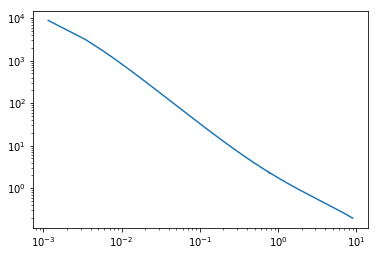

In [14]:
plt.loglog((median_m(M2)-M1)/M1,merger_r)

In [4]:
# calculate theoritical hmf
redshift = 0.45
M    = 10.**np.arange(11,15.5,0.01)/1e10
zz   = redshift*np.ones(M.shape[0],dtype=np.double)
DZ   = np.zeros(M.shape[0],dtype=np.double)
sigm = np.zeros(M.shape[0],dtype=np.double)

PSH.prepare()
PSH.main_power.restype = None
PSH.main_power(ctypes.c_int(M.shape[0]),
               numpy.ctypeslib.as_ctypes(zz),
               numpy.ctypeslib.as_ctypes(M),
               numpy.ctypeslib.as_ctypes(DZ),
               numpy.ctypeslib.as_ctypes(sigm))


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


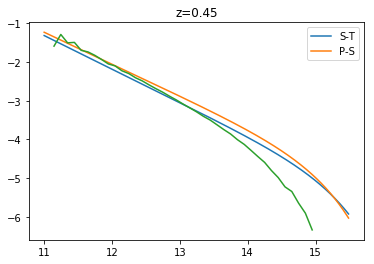

In [5]:
dc = 1.686*DZ[0] #dc/DZ DZ-growth factor at redshift z
fst   = ST(sigm)
fps   = PS(sigm)
dm    = M[1:]-M[:-1]
dlnsm = np.log(sigm[1:])-np.log(sigm[:-1])
plt.plot(np.log10(median_m(M)*1e10),np.log10(-np.log(10)*median_m(fst)*dlnsm/dm*7.43834e-09*1e9),label='S-T',alpha=1)
plt.plot(np.log10(median_m(M)*1e10),np.log10(-np.log(10)*median_m(fps)*dlnsm/dm*7.43834e-09*1e9),label='P-S',alpha=1)
xsimu = np.loadtxt('../data/w_1/fofmassfunc'+np.str(redshift)+'.dat')
plt.plot(xsimu[:,0],np.log10(xsimu[:,1]))
plt.title('z='+np.str(redshift))
plt.legend()

In [9]:
#np.savetxt('temp/z0.45-tophat-M.dat',np.vstack((M,sigm)))
#np.savetxt('temp/z0.45-sharpk-M.dat',np.vstack((M,sigm)))

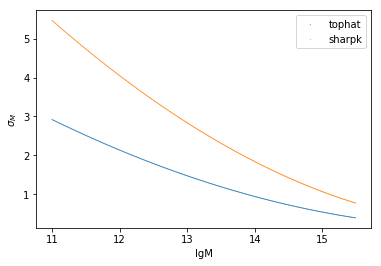

In [11]:
xtop = np.loadtxt('temp/z0.45-tophat-M.dat')
plt.scatter(np.log10(xtop[0])+10,xtop[1],s=1,edgecolors='none',label='tophat')
plt.scatter(np.log10(M)+10,sigm,s=1,edgecolors='none',label='sharpk')
plt.xlabel('lgM')
plt.ylabel(r'$\sigma_M$')
plt.legend()